# CCT College

###### Module Title(s):	
Machine Learning for AI
###### Lecturer Name(s):	
David McQuaid
###### Assessment Title:	
ML_CA1
###### Student Name: 
Tamiris Rodrigues Duarte
###### Student Number:
2020294
###### Due Date (Deadline):	
22th April 2024

###### GitHub:	
https://github.com/tamirisrd/ML_CA1

### 1 Dataset

To analyse the data, the columns 'Source Port' and 'Destination Port' were chosen to be worked with the feature "Action" as the dataset is quite large. The objective was to reduce the amount of data to be analysed but still try to get conclusive results related to the attempts to access a firewall. Of all the columns in the dataset, the ones chosen were the most relevant to the matter, as port numbers can indicate malicious activity. 

I checked the type of data the original dataset had to know which type of data I would be dealing with and if any other column besides 'Action' needed to be encoded, as Machine learning deals better with numerical data. I checked for missing values in case they needed some modification, but they did not show any. I separated categorical and numerical data for preprocessing, used StandardScaler on the numerical, and grouped them, transforming them into a temporary variable to have a brief understanding of how the data might be.

A histogram shows that the number of ports responsible for reset-both is minimal compared to the other three alternatives. All denied Source Ports have an access frequency of less than 1000, while the authorised ones vary but are higher than the denied ones. However, when switching to Destination Ports, the frequency analysed is much higher than the Source Port frequency, and there is a drastic difference between the Destination Ports. The higher the port number, the less frequency.

### 2 Classifications

For the classifications, the chosen one was the KNearest-Neighbour 
(KNN) and Random Forest. The KNN was selected to have in mind the simplicity of the implementation and the ability of the model to predict and find patterns in the relationship between the Ports and the Actions (allow, deny, drop and reset-both).

Random Forest was chosen because it can deal with randomness. Although I did not check for any skewness, I decided to opt for one classification that would deal with it if the dataset contained it. 

The Validation Curve was used to assess how the performance metrics change with different values and understand whether there is a case of overfitting or underfitting. The results of KNearest-Neighbour can be considered overfitting if the curves are too similar, while Random Forest indicates underfitting as the curves are far from each other.  

In [1]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
import sklearn.preprocessing as preproc
from sklearn.impute import SimpleImputer
from sklearn.datasets import load_digits
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
# Read file
df = pd.read_csv("log2.csv")
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Action
0,57222,53,54587,53,177,94,83,2,30,1,1,allow
1,56258,3389,56258,3389,4768,1600,3168,19,17,10,9,allow
2,6881,50321,43265,50321,238,118,120,2,1199,1,1,allow
3,50553,3389,50553,3389,3327,1438,1889,15,17,8,7,allow
4,50002,443,45848,443,25358,6778,18580,31,16,13,18,allow


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Bytes                 65532 non-null  int64 
 5   Bytes Sent            65532 non-null  int64 
 6   Bytes Received        65532 non-null  int64 
 7   Packets               65532 non-null  int64 
 8   Elapsed Time (sec)    65532 non-null  int64 
 9   pkts_sent             65532 non-null  int64 
 10  pkts_received         65532 non-null  int64 
 11  Action                65532 non-null  object
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [4]:
# Check missing values
missing_values = df.isnull().sum()
print(missing_values)

Source Port             0
Destination Port        0
NAT Source Port         0
NAT Destination Port    0
Bytes                   0
Bytes Sent              0
Bytes Received          0
Packets                 0
Elapsed Time (sec)      0
pkts_sent               0
pkts_received           0
Action                  0
dtype: int64


In [5]:
df.describe()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.000000,65532.000000,65532.000000,65532.000000,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,49391.969343,10577.385812,19282.972761,2671.049930,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,15255.712537,18466.027039,21970.689669,9739.162278,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,49183.000000,80.000000,0.000000,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,53776.500000,445.000000,8820.500000,53.000000,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,58638.000000,15000.000000,38366.250000,443.000000,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,65534.000000,65535.000000,65535.000000,65535.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


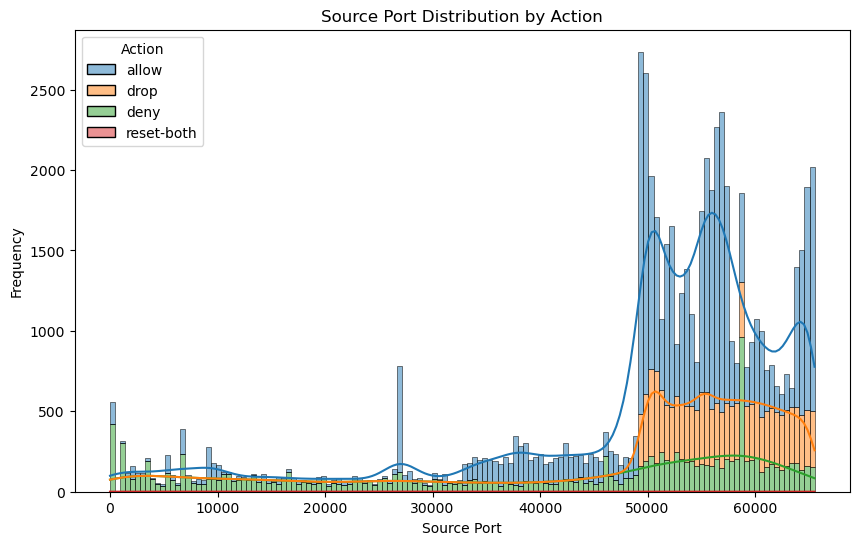

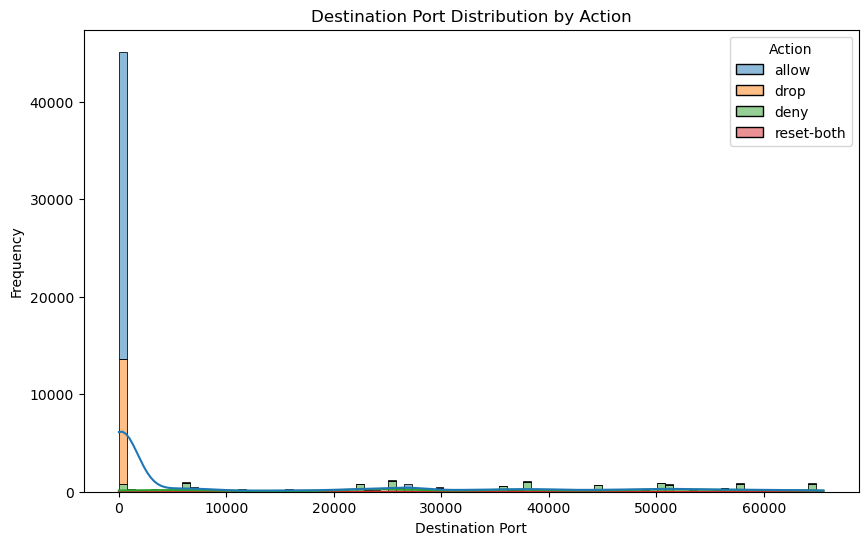

In [6]:
# Action x Source Port plot
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Source Port', hue='Action', multiple='stack', kde=True)
plt.title('Source Port Distribution by Action')
plt.xlabel('Source Port')
plt.ylabel('Frequency')
plt.show()

# Action x Destination Port plot
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Destination Port', hue='Action', multiple='stack', kde=True)
plt.title('Destination Port Distribution by Action')
plt.xlabel('Destination Port')
plt.ylabel('Frequency')
plt.show()

In [7]:
# Create the new dataset with "Source Port", "Destination Port", and "Action" columns
logs = df[['Source Port', 'Destination Port', 'Action']]
logs.head()

,Source Port,Destination Port,Action
0,57222,53,allow
1,56258,3389,allow
2,6881,50321,allow
3,50553,3389,allow
4,50002,443,allow


C:\Users\tahro\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


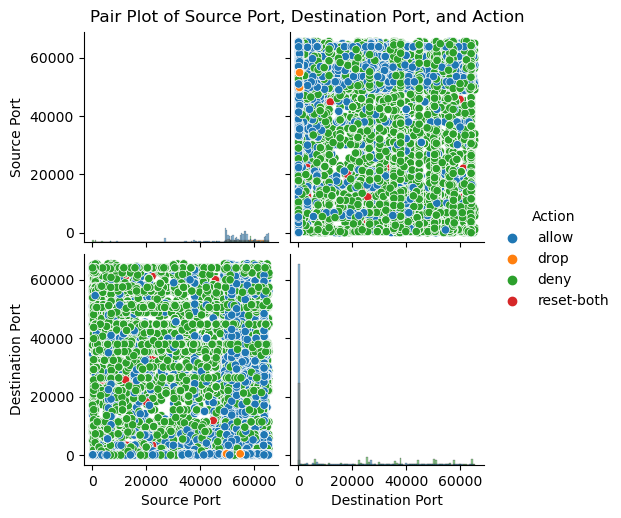

In [8]:
sns.pairplot(logs, hue='Action', diag_kind='hist')
plt.suptitle('Pair Plot of Source Port, Destination Port, and Action', y=1.02)
plt.show()

In [9]:
# Categorical columns 

cat_col_df = ['Source Port', 'Destination Port', 'Action']


# Define categorical data transformation pipeline

impute_cat = SimpleImputer (strategy='most_frequent')
onehot_cat = OneHotEncoder(handle_unknown='ignore')
cat_transformer = Pipeline(steps=[('impute', impute_cat),('onehot',onehot_cat)])


In [10]:
# Numerical columns

num_col = logs.select_dtypes(include=[np.float64,np.int64]).columns

scaler_num = StandardScaler()

num_col_trans = Pipeline(steps=[('scale', scaler_num)])

In [11]:
# Preprocess categorical and numerical columns

cat_col_prepro = ColumnTransformer (transformers = [('cat', cat_transformer,
                                                    cat_col_df)],
                                   remainder="passthrough")
all_col_prepro = ColumnTransformer(transformers =[('cat', cat_transformer, cat_col_df),
                                                          ('num', num_col_trans, num_col)],
                                             remainder="passthrough")
# Transform
df_temp = cat_col_prepro.fit_transform(logs)
print("Data temp after transforming: " )
print(df_temp)
df_temp_2 = all_col_prepro.fit_transform(logs) 
print("Data temp 2 after transforming: " )
print(df_temp_2)

Data temp after transforming: 
  (0, 15780)	1.0
  (0, 22734)	1.0
  (0, 25997)	1.0
  (1, 14847)	1.0
  (1, 22907)	1.0
  (1, 25997)	1.0
  (2, 636)	1.0
  (2, 25301)	1.0
  (2, 25997)	1.0
  (3, 9697)	1.0
  (3, 22907)	1.0
  (3, 25997)	1.0
  (4, 9166)	1.0
  (4, 22750)	1.0
  (4, 25997)	1.0
  (5, 10523)	1.0
  (5, 22750)	1.0
  (5, 25997)	1.0
  (6, 18575)	1.0
  (6, 25120)	1.0
  (6, 25997)	1.0
  (7, 9211)	1.0
  (7, 22750)	1.0
  (7, 25997)	1.0
  (8, 11274)	1.0
  :	:
  (65523, 25998)	1.0
  (65524, 12688)	1.0
  (65524, 24528)	1.0
  (65524, 25998)	1.0
  (65525, 22516)	1.0
  (65525, 22734)	1.0
  (65525, 25997)	1.0
  (65526, 10740)	1.0
  (65526, 24885)	1.0
  (65526, 25997)	1.0
  (65527, 21002)	1.0
  (65527, 22739)	1.0
  (65527, 25997)	1.0
  (65528, 10093)	1.0
  (65528, 22739)	1.0
  (65528, 25997)	1.0
  (65529, 13542)	1.0
  (65529, 22752)	1.0
  (65529, 25999)	1.0
  (65530, 13541)	1.0
  (65530, 22752)	1.0
  (65530, 25999)	1.0
  (65531, 13538)	1.0
  (65531, 22752)	1.0
  (65531, 25999)	1.0
Data temp 2 after 

In [12]:
# Label enconding

label_encoder = LabelEncoder()
label = label_encoder.fit_transform(logs['Action'])

print(label)

[0 0 0 ... 2 2 2]


In [13]:
# split data for training and validation
X = logs.drop(['Action'], axis=1)
y = label

In [14]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y , random_state=1)

###  K-Nearest Neighbors

In [15]:
# KNN model training
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean')

In [16]:
y_pred = knn.predict(X_train)

C:\Users\tahro\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


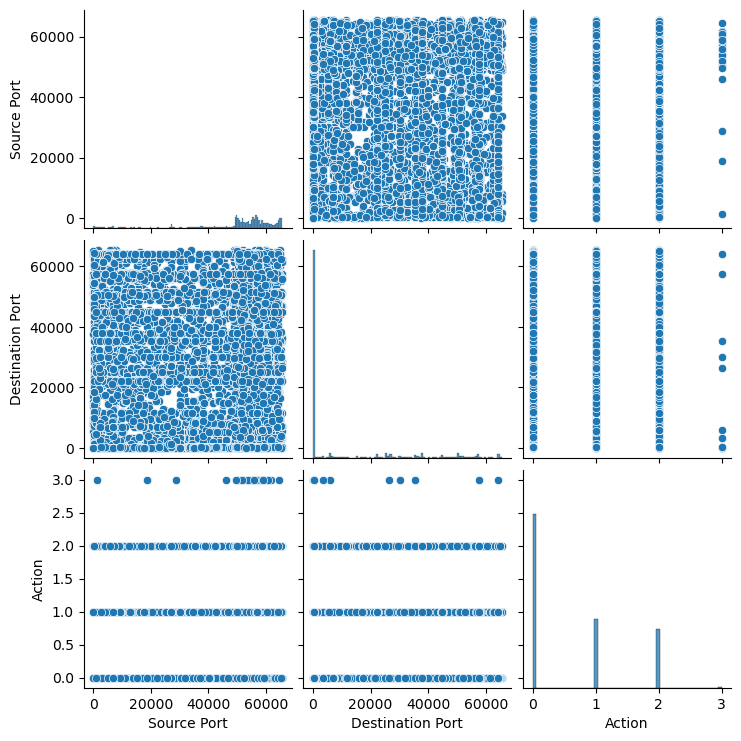

In [17]:
pairplot_data = pd.concat([X_train, pd.Series(y_train, name='Action')], axis=1)
sns.pairplot(pairplot_data)
plt.show()

In [18]:
# Evaluate KNN model
y_pred_knn_validation = knn.predict(X_validation)

accuracy_knn = accuracy_score(y_validation, y_pred_knn_validation)

precision_knn = precision_score(y_validation, y_pred_knn_validation, average='weighted')

recall_knn = recall_score(y_validation, y_pred_knn_validation, average='weighted')

f1_score_knn = f1_score(y_validation, y_pred_knn_validation, average='weighted')

conf_matrix_knn = confusion_matrix(y_validation, y_pred_knn_validation)

C:\Users\tahro\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
# KNN evaluation metrics

print("KNN Model Evaluation:")
print("Accuracy:", accuracy_knn)
print("Precision:", precision_knn)
print("Recall:", recall_knn)
print("F1 Score:", f1_score_knn)
print("Confusion Matrix:")
print(conf_matrix_knn)

KNN Model Evaluation:
Accuracy: 0.885307941158518
Precision: 0.8856927672029167
Recall: 0.885307941158518
F1 Score: 0.8853529906564064
Confusion Matrix:
[[8316  342  666    0]
 [ 350 3441    8    0]
 [ 498    2 2747    0]
 [   5    8    0    0]]


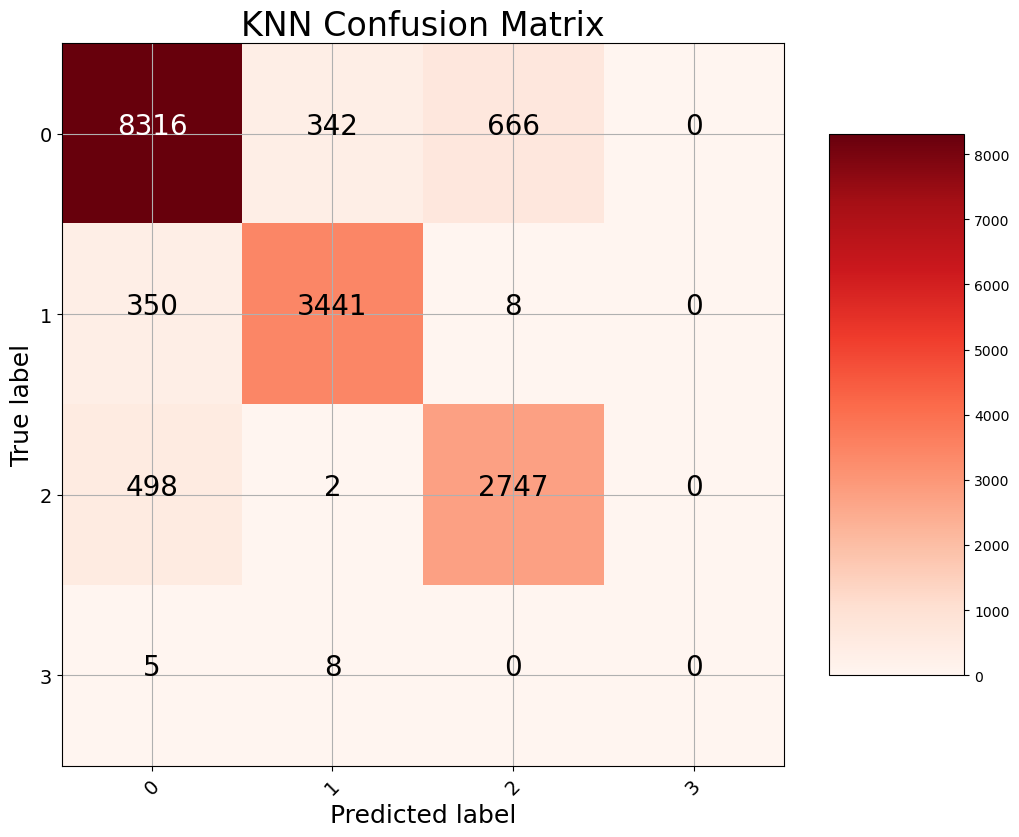

In [20]:
# KNN Confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=14)
    plt.yticks(tick_marks, classes, size=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size=18)
    plt.xlabel('Predicted label', size=18)

# Plot KNN confusion matrix 
plot_confusion_matrix(conf_matrix_knn, classes=['0', '1', '2', '3'], title='KNN Confusion Matrix')
plt.show()

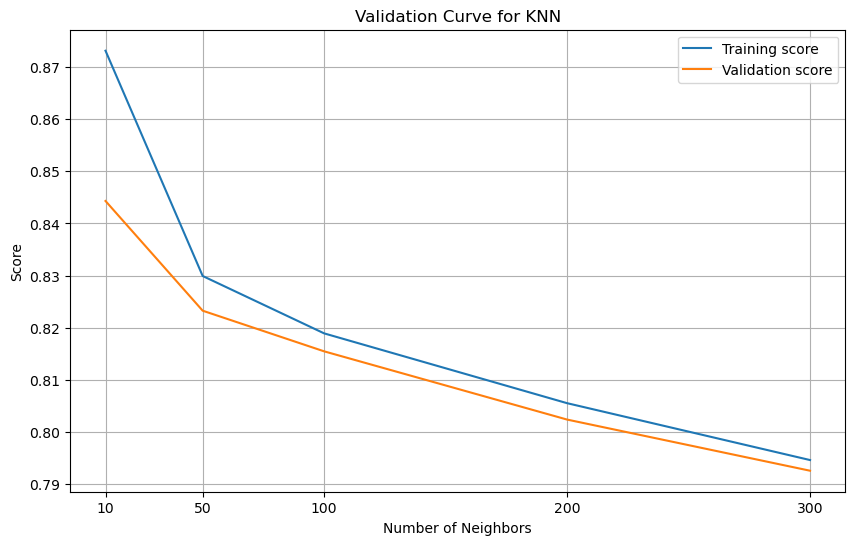

In [21]:
# Validation Curve KNN

# Define the range of values for the hyperparameter
param_range = [10, 50, 100, 200, 300]

# Compute training and validation scores for different values of n_neighbors
train_scores, test_scores = validation_curve(
    KNeighborsClassifier(metric='euclidean'), X_train, y_train,
    param_name="n_neighbors", param_range=param_range, cv=5
)

plt.figure(figsize=(10, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label="Training score")
plt.plot(param_range, np.mean(test_scores, axis=1), label="Validation score")
plt.title("Validation Curve for KNN")
plt.xlabel("Number of Neighbors")
plt.ylabel("Score")
plt.xticks(param_range)
plt.legend()
plt.grid(True)
plt.show()

### Random Forest

In [22]:
# Trai RF model
rfc_model = RandomForestClassifier (n_estimators=100, random_state = 42)

In [23]:
rfc_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [24]:
y_pred_rf = rfc_model.predict(X_train)

C:\Users\tahro\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


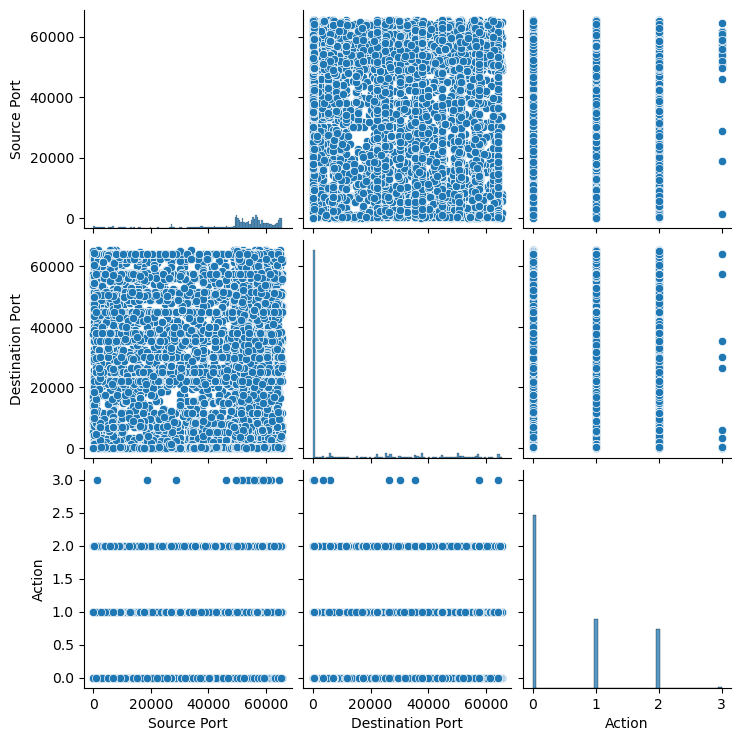

In [25]:
pairplot_data_rf = pd.concat([X_train, pd.Series(y_pred_rf, name='Action')], axis=1)
sns.pairplot(pairplot_data_rf)
plt.show()

In [26]:
# Evaluate Random Forest model
y_pred_rf_validation = rfc_model.predict(X_validation)

accuracy_rf = accuracy_score(y_validation, y_pred_rf_validation)

precision_rf = precision_score(y_validation, y_pred_rf_validation, average='weighted')

recall_rf = recall_score(y_validation, y_pred_rf_validation, average='weighted')

f1_score_rf = f1_score(y_validation, y_pred_rf_validation, average='weighted')

conf_matrix_rf = confusion_matrix(y_validation, y_pred_rf_validation)

C:\Users\tahro\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
# RF evaluation metrics

print("\nRandom Forest Model Evaluation:")
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1 Score:", f1_score_rf)
print("Confusion Matrix:")
print(conf_matrix_rf)


Random Forest Model Evaluation:
Accuracy: 0.9843130073857047
Precision: 0.9836542712441187
Recall: 0.9843130073857047
F1 Score: 0.9839626071619574
Confusion Matrix:
[[9182  142    0    0]
 [  85 3706    8    0]
 [   0    9 3238    0]
 [   5    8    0    0]]


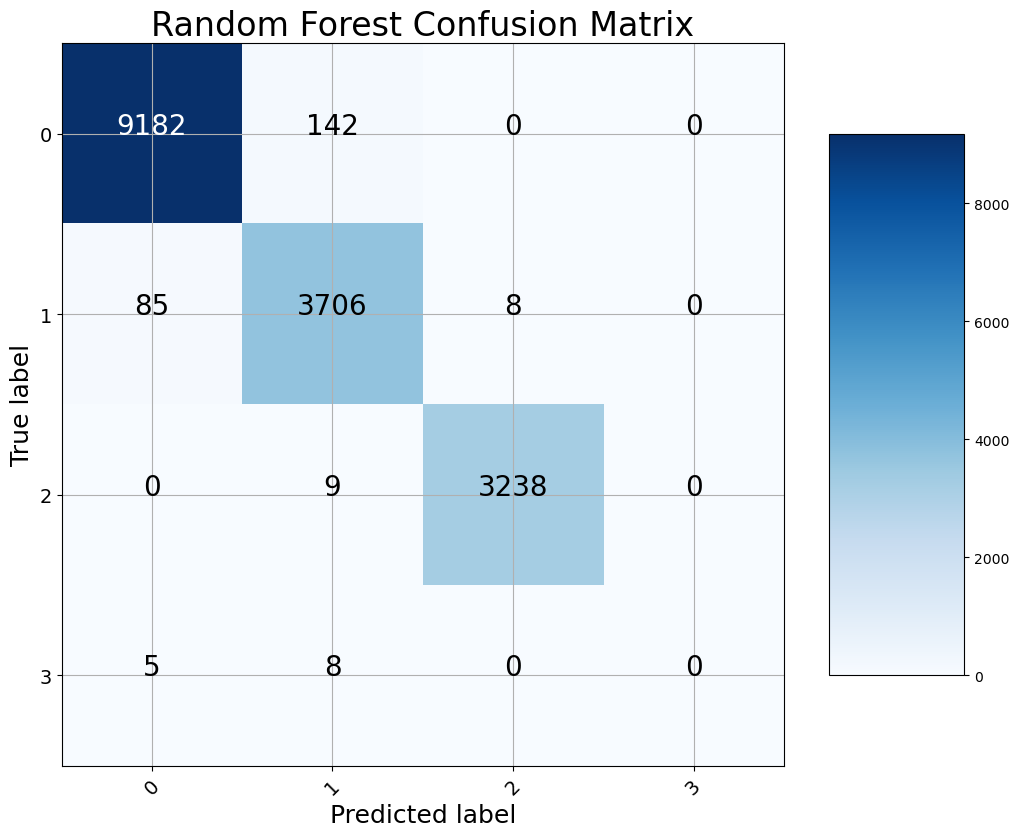

In [28]:
# RF Confusion Matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=14)
    plt.yticks(tick_marks, classes, size=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size=18)
    plt.xlabel('Predicted label', size=18)

# Plot RF confusion matrix using
plot_confusion_matrix(conf_matrix_rf, classes=['0', '1', '2','3'], title='Random Forest Confusion Matrix')
plt.show()

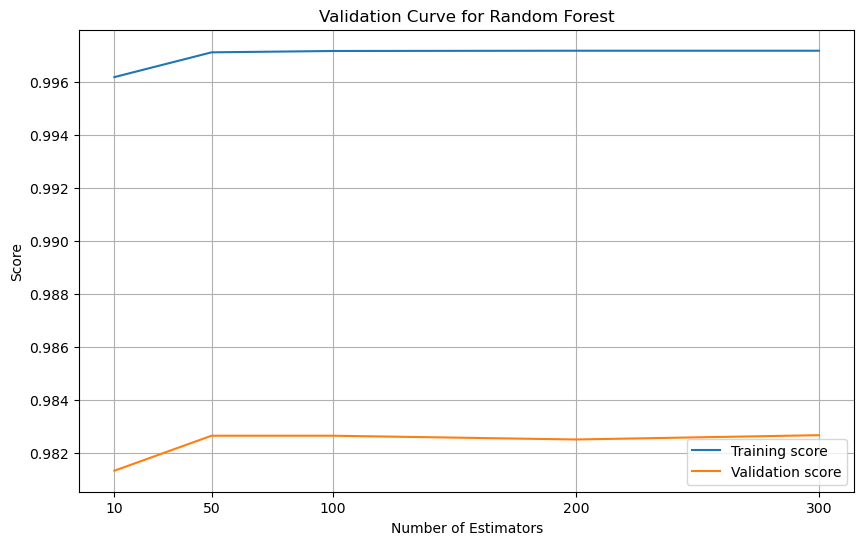

In [29]:
# Validation Curve RF

# Define the range of values for hyperparameter
param_range = [10, 50, 100, 200, 300]

# Compute training and validation scores for different values of n_neighbors
train_scores, test_scores = validation_curve(
    RandomForestClassifier(), X_train, y_train,
    param_name='n_estimators', param_range=param_range, cv=5
)

plt.figure(figsize=(10, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Validation score')
plt.title('Validation Curve for Random Forest')
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.xticks(param_range)
plt.legend()
plt.grid(True)
plt.show()

### References

In addition to classroom materials

(No date) scikit. Available at: https://scikit-learn.org/stable/index.html (Accessed: 22 April 2024). 

Clarke, M. (2021) How to use category encoders to encode categorical variables, Practical Data Science. Available at: https://practicaldatascience.co.uk/machine-learning/how-to-encode-categorical-variables-for-machine-learning (Accessed: April 2024). 

Evaluation metrics in machine learning (2023) GeeksforGeeks. Available at: https://www.geeksforgeeks.org/metrics-for-machine-learning-model/ (Accessed: April 2024). 

Madhavan, S. (2019a) Build and Test your First Machine Learning Movel Using Python and Scikit Learn, IBM developer. Available at: https://developer.ibm.com/tutorials/build-and-test-your-first-machine-learning-model-using-python-and-scikit-learn/ (Accessed: April 2024). 

Madhavan, S. (2019b) Learn classification algorithms using Python and scikit-learn, IBM developer. Available at: https://developer.ibm.com/tutorials/learn-classification-algorithms-using-python-and-scikit-learn/ (Accessed: April 2024). 

Parker, J.W.S. (2023) What is the role of firewall logs in security analysis?, James Parker. Available at: https://www.jamesparker.dev/what-is-the-role-of-firewall-logs-in-security-analysis/ (Accessed: April 2024). 

Plotting validation curves (no date) scikit. Available at: https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py (Accessed: April 2024). 